In [21]:
import numpy as np
import psycopg2
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [22]:
# from run_mcts import Game, StabilityNode

# G = Game(StabilityNode, 'C')
# node = G.run_mcts().__next__()

In [23]:
import os
import sys
sys.path.append('..')

from alphazero import config
import stable_rad_config

In [24]:
config.experiment_id

'debug'

Text(0.5, 0, 'Time (hours)')

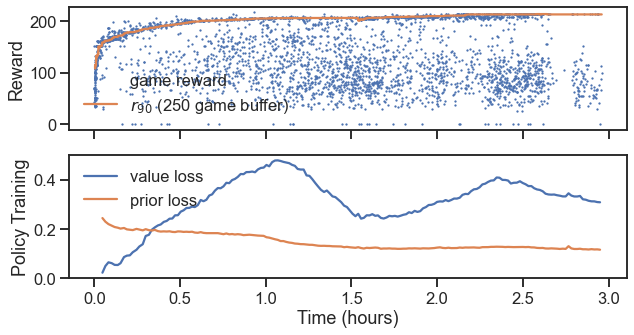

In [129]:
# Load the game buffer
with psycopg2.connect(**config.dbparams) as conn:
    df = pd.read_sql_query("select * from {}_game where experiment_id = %s".format(
        config.sql_basename), conn, params=(config.experiment_id,))
    
# Load the policy training history
try:
    log = pd.read_csv(os.path.join(config.checkpoint_filepath, 'log.csv'))
    log['time'] = pd.to_datetime(log.time)
except Exception:
    log = None

df['time_hours'] = (df.time - df.time.min()).apply(lambda x: x.total_seconds() / 3600)

if log is not None:
    log['time_hours'] = (log.time - df.time.min()).apply(lambda x: x.total_seconds() / 3600)

df = df.sort_values('time_hours')

fig, axs = plt.subplots(sharex=True, nrows=2, figsize=(10, 5))

axs[0].plot(df.time_hours, df.real_reward, '.', ms=2.5, label='game reward')
axs[0].plot(df.time_hours, df.real_reward.rolling(250, min_periods=50).quantile(.9), label='$r_{90}$ (250 game buffer)')

if log is not None:
    axs[1].plot(log.time_hours, log.policy_wrapper_loss, label='value loss')
    axs[1].plot(log.time_hours, log.policy_wrapper_1_loss, label='prior loss')

axs[1].legend()
axs[0].legend()

# axs[0].set_ylim([0, 150])

axs[0].set_ylabel('Reward')
axs[1].set_ylabel('Policy Training')
axs[1].set_xlabel('Time (hours)')

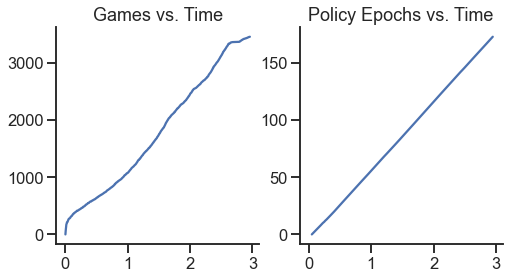

In [142]:
fig, axs = plt.subplots(figsize=(8,4), sharex=True, ncols=2)
axs[0].plot(df.time_hours, df.index)
axs[1].plot(log.time_hours, log.index)

axs[0].set_title('Games vs. Time')
axs[1].set_title('Policy Epochs vs. Time')

sns.despine()

In [52]:
with psycopg2.connect(**config.dbparams) as conn:
    experiment_ids = pd.read_sql_query("select distinct experiment_id from {}_game".format(config.sql_basename), conn)
    
experiment_ids

,experiment_id
0,debug


In [59]:
# Load the reward buffer to plot the optimal molecules
with psycopg2.connect(**config.dbparams) as conn:
    rew_df = pd.read_sql_query("select * from {}_reward".format(config.sql_basename), conn)

rew_df.shape

(653635, 10)

In [61]:
rew_df.sort_values('real_reward', ascending=False).head(10)

,smiles,time,real_reward,atom_type,buried_vol,max_spin,atom_index,ie,ea,bde
627385,CCCN(C(NO)=C([NH])N)C(C)(C)CC,2020-12-09 16:40:00.577268,218.22968,N,80.352920,0.242465,3,0.899228,-0.204454,74.43683
312411,CCCN(C(NC)=C([NH])N)C(CC)CC,2020-12-09 15:08:43.024536,216.87169,N,79.555740,0.253681,3,0.873657,-0.173863,74.22462
650486,CCCN(C(NO)=C([NH])O)C(C)(C)CC,2020-12-09 16:55:41.895795,216.32938,N,80.120630,0.275825,3,0.979265,-0.337284,71.29948
530790,CCCN(C(NN)=C([NH])N)C(CC)CC,2020-12-09 15:54:07.144250,214.90234,N,79.304535,0.288044,3,0.772688,-0.200174,74.29749
349855,CCCN(C(NO)=C(C)[NH])C(CC)CC,2020-12-09 15:15:01.309984,214.30252,N,79.206440,0.298079,3,0.926269,-0.266680,75.96210
531532,CCCN(C(=C([NH])N)N(C)O)C(C)(C)C,2020-12-09 15:54:18.908457,214.19493,N,76.571434,0.247530,3,0.814302,-0.342940,75.69568
581385,CN(O)C(=C([NH])N)N(CCO)C(C)(C)C,2020-12-09 16:14:36.215743,214.08461,N,77.341040,0.265129,7,0.820386,-0.365029,75.69568
556315,CCC([NH])=C(NN)N(CC)C(CC)CC,2020-12-09 16:04:13.152459,213.42702,N,76.647934,0.247443,7,0.615964,-0.340740,76.81633
614820,[CH2]C(NO)=C(N)N(CC(C)C)C(C)(C)C,2020-12-09 16:32:36.939098,213.20170,N,75.379500,0.243556,6,0.760036,-0.362465,75.71036
627438,CCCN(C(=C([NH])O)N(C)O)C(C)(C)C,2020-12-09 16:40:03.134770,213.08958,N,76.103630,0.260281,3,0.983063,-0.373251,72.58222


In [91]:
stable_df = pd.read_csv('/home/pstjohn/Research/20200608_redox_calculations/stable_radicals/spin-charges-bur-vol-stable-radicals-all-atoms-with-smi.csv')

stable_df_noH = stable_df[~stable_df['atom-sym-idx'].str.startswith('H')]
stable_df['fractional_spin'] = stable_df_noH.groupby('File')['spin-density'].transform(lambda x: x.abs() / x.abs().sum())

stable_idx_max_spin = stable_df.groupby('File').fractional_spin.idxmax()
stable_max_spin = stable_df.loc[stable_idx_max_spin]

In [93]:
stable_df.File.unique()

array(['verdazyl.log', 'nn.log', 'proxyl.log', 's-proxyl.log',
       'tempo.log', 'tban.log', 'galvinoxyl.log', 'trityl.log'],
      dtype=object)

In [94]:
stable_max_spin

,File,Name,Smiles,mol-block,atom-idx-log,atom-idx-smi,atom-sym,atom-sym-idx,spin-density,bur-vol,fractional_spin
213,galvinoxyl.log,galvinoxyl,[H][C](c1c([H])c(C(C([H])([H])[H])(C([H])([H])...,galvinoxyl.log\n RDKit 3D\n\n 72 ...,69,68,O,O69,0.862357,48.895910,0.788403
19,nn.log,nn,[H][C]1N([O])C(C([H])([H])[H])(C([H])([H])[H])...,nn.log\n RDKit 3D\n\n 24 24 0 0...,4,3,N,N4,0.312982,53.123845,0.198361
47,proxyl.log,proxyl,[H]C([H])([H])C1(C([H])([H])[H])N([O])C(C([H])...,proxyl.log\n RDKit 3D\n\n 26 26 ...,8,7,N,N8,0.535764,64.129450,0.495385
71,s-proxyl.log,s-proxyl,[H]C1=C([H])C(C([H])([H])[H])(C([H])([H])[H])N...,s-proxyl.log\n RDKit 3D\n\n 24 24...,6,5,N,N6,0.534125,62.448678,0.483977
129,tban.log,tban,[H]c1c([H])c([H])c(N([O])C(C([H])([H])[H])(C([...,tban.log\n RDKit 3D\n\n 26 26 0 ...,11,10,N,N11,0.475338,59.130547,0.333018
100,tempo.log,tempo,[H]C([H])([H])C1(C([H])([H])[H])[N+]([O-])C(C(...,tempo.log\n RDKit 3D\n\n 29 29 0...,11,10,N,N11,0.515589,66.918176,0.461123
217,trityl.log,trityl,[H]c1c([H])c([H])c([C](c2c([H])c([H])c([H])c([...,trityl.log\n RDKit 3D\n\n 34 36 ...,1,0,C,C1,0.564118,64.272466,0.246013
3,verdazyl.log,verdazyl,[H]C1=NN(C([H])([H])[H])C(=O)N(C([H])([H])[H])...,verdazyl.log\n RDKit 3D\n\n 16 16...,4,3,N,N4,0.408672,38.745615,0.273034


In [109]:
pass_gng = rew_df[(rew_df.bde < 80) & (rew_df.bde > 60) &
                  (rew_df.ie < 1.2) & (rew_df.ea > -.5) &
                  ((rew_df.ie - rew_df.ea) > 1) &
                  ((rew_df.buried_vol + 50 * (1 - rew_df.max_spin)) > 100.)]

In [128]:
pass_gng.shape

(4245, 10)

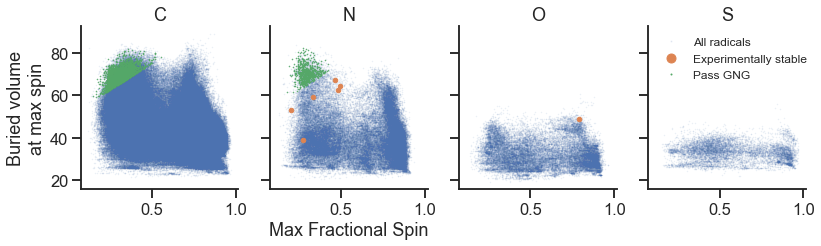

In [114]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(13, 3), sharex=True, sharey=True)

optimal = []
for ax, atom in zip(axs, ['C', 'N', 'O', 'S']):
    
    ax.plot(rew_df[rew_df.atom_type == atom]['max_spin'],
            rew_df[rew_df.atom_type == atom]['buried_vol'], '.', ms=1, alpha=.1, label='All radicals')
    
    ax.plot(stable_max_spin[stable_max_spin['atom-sym'] == atom]['fractional_spin'],
            stable_max_spin[stable_max_spin['atom-sym'] == atom]['bur-vol'],
            '.', label='Experimentally stable')
    
    ax.plot(pass_gng[pass_gng.atom_type == atom]['max_spin'],
            pass_gng[pass_gng.atom_type == atom]['buried_vol'], '.', ms=1, label='Pass GNG')
    
    ax.set_title(atom)
    
axs[1].set_xlabel('Max Fractional Spin')
axs[0].set_ylabel('Buried volume\nat max spin')

axs[-1].legend(loc='upper left', fontsize=12, markerscale=2)
sns.despine()    

Text(0, 0.5, '$E_{1/2}^o$, IE (V)')

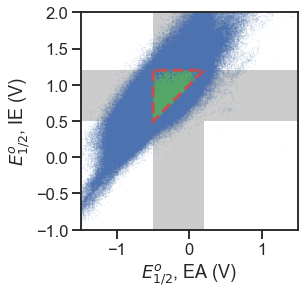

In [120]:
from matplotlib.patches import Polygon

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')

ax.plot(rew_df['ea'], rew_df['ie'], '.', ms=1, alpha=.1)
ax.plot(pass_gng['ea'], pass_gng['ie'], '.', ms=1, color='g')

ax.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none', zorder=5, edgecolor='r', lw=3, ls='--'))
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1, 2])

ax.axvspan(-.5, .2, facecolor='.8', edgecolor='none')
ax.axhspan(.5, 1.2, facecolor='.8', edgecolor='none')

ax.set_xlabel(r'$E_{1/2}^o$, EA (V)')
ax.set_ylabel(r'$E_{1/2}^o$, IE (V)')

<AxesSubplot:>

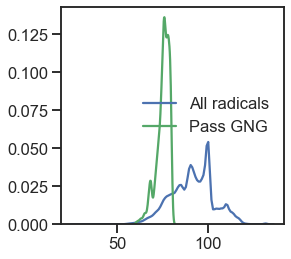

In [127]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

sns.kdeplot(rew_df.bde, label='All radicals')
sns.kdeplot(pass_gng.bde, label='Pass GNG', color='g')

In [143]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
import nfp

In [144]:
from reward import predict, stability_model
from alphazero.node import Node

def pred_spins(mol):
    spins, _ = predict(stability_model, 
        {key: tf.constant(np.expand_dims(val, 0))
         for key, val in Node(mol).policy_inputs.items()})
    
    return spins.numpy().flatten()

In [155]:
# Code for raster image drawing
import rdkit

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import rdDepictor
from IPython.display import SVG

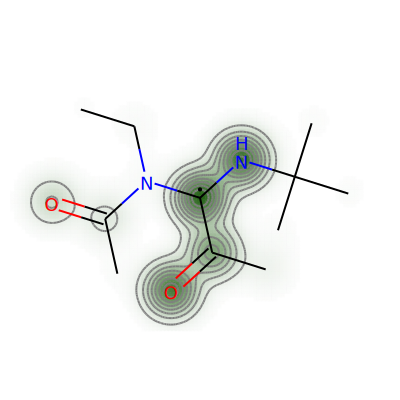

In [162]:
row = pass_gng.sample(1, random_state=5).iloc[0]
mol = Chem.MolFromSmiles(row.smiles)

d = rdMolDraw2D.MolDraw2DSVG(400, 400)
SimilarityMaps.GetSimilarityMapFromWeights(mol, [float(i) for i in pred_spins(mol)], draw2d=d)
d.FinishDrawing()
SVG(d.GetDrawingText())